# Visualize the high-level taxonomic composition of metagenome samples

Sourmash `gather` compares a query (here, a metagenome) against a database (GenBank microbial genomes) and provides the minimum set of genomes the cover all of the k-mers in the query that are in the database. 

Sourmash `gather` works best for metagenomes from environments that have been sequenced before or from which many genomes have been isolated and sequenced.
Because k-mers are so specific, a genome needs to be in a database for sourmash `gather` to find a match. 
Sourmash `gather` won't find much above species (k = 31) or genus (k = 21) similarity, so if most of the organisms in a sample are new, sourmash won't be able to label them.

Sourmash `taxonomy` makes the sourmash `gather` output more interpretable. 
Previously, sourmash `gather` only output the statistics about the genomes in a database that were found in a metagenome.  
While this information is useful, taxonomic labels allow agglomeration up the taxonomic lineage to summarize results. 

This notebook uses the results from sourmash `gather` and `taxonomy` and visualizes the high-level composition of the metagenome samples.

The actual number that is plotted is referred to as abundance-weighted unique fraction. 
By default, sourmash `gather` returns the following information:

* `intersect_bp`: the estimated number of base pairs that overlapped between the query and the matched genome
* `f_orig_query`: the fraction of the orginal query (metagenome sample) that matched against the genome
* `f_match`: the fraction of the genome in the database that matched against the original query (metagenome sample)
* `f_unique_to_query`: the fraction of the matched genome that was unique to the query. Given that multiple matched genomes could cover the same portion of the query, this column reports the fraction of the query that was covered by the a matched genome, but doesn't allow multiple genomes to cover the same portion. As such, the genome that covers the most k-mers in a metagenome sample gets to "anchor" those k-mers, while other genomes that could cover those k-mers don't get any of them. This column removes the double counting problem that arises from having multiple genomes in a database that contain some of the same sequences.
* `f_unique_weighted`: This column weights the `f_unique_to_query` by the abundance of those k-mers. This is important in the context of a metagenome, as the abundance reflects the abundance of the genome in the original microbial communit.

The plots below use `f_unique_weighted` to look at the taxonomic composition of each metagenome sample.

In [1]:
# the default directory is the "notebooks" folder; set it one level up.
setwd("..")

In [2]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

In [4]:
library(readr)
library(dplyr)
library(tidyr)
library(purrr)
library(tibble)
library(ggplot2)
library(ggthemes)
library(ggpubr)
library(ComplexUpset)

In [5]:
# read in functions (fromList(), read_gather())
source("scripts/utils.R")

## Read in `sourmash taxonomy` results

In [6]:
# USER-DEFINED FILTERING THRESHOLD
# This repository sets sourmash gather's --threshold-bp parameter to 0, meaning we will return all matches even if there is only 1 k-mer overlap.
# Because we only want to work with results we are confident, we'll set a filtering threshold.
# I think 50,000bp (equivalent to 50 hashes) is a stringent threshold.
# This number is probably least appropriate for viruses and community members that are present at very low abundance (e.g. potential archaea).
intersect_bp_threshold <- 50000

In [8]:
sourmash_taxonomy <- Sys.glob("outputs/sourmash_taxonomy/wh*k31*csv") %>%
  map_dfr(read_gather) %>% # read in files
  separate(lineage, into = c("kingdom", "phylum", "class", "order", "family", "genus", "species", "strain"),
           sep = ";", remove = F, fill = "right") %>% # separate lineage column into commensurate parts
  mutate(database = basename(filename),
         database = gsub("genbank-2022.03-", "", database),
         database = gsub("-k31.zip", "", database)) %>%
  filter(intersect_bp >= intersect_bp_threshold)

## Plot fraction of samples assigned to each domain & fraction unclassified

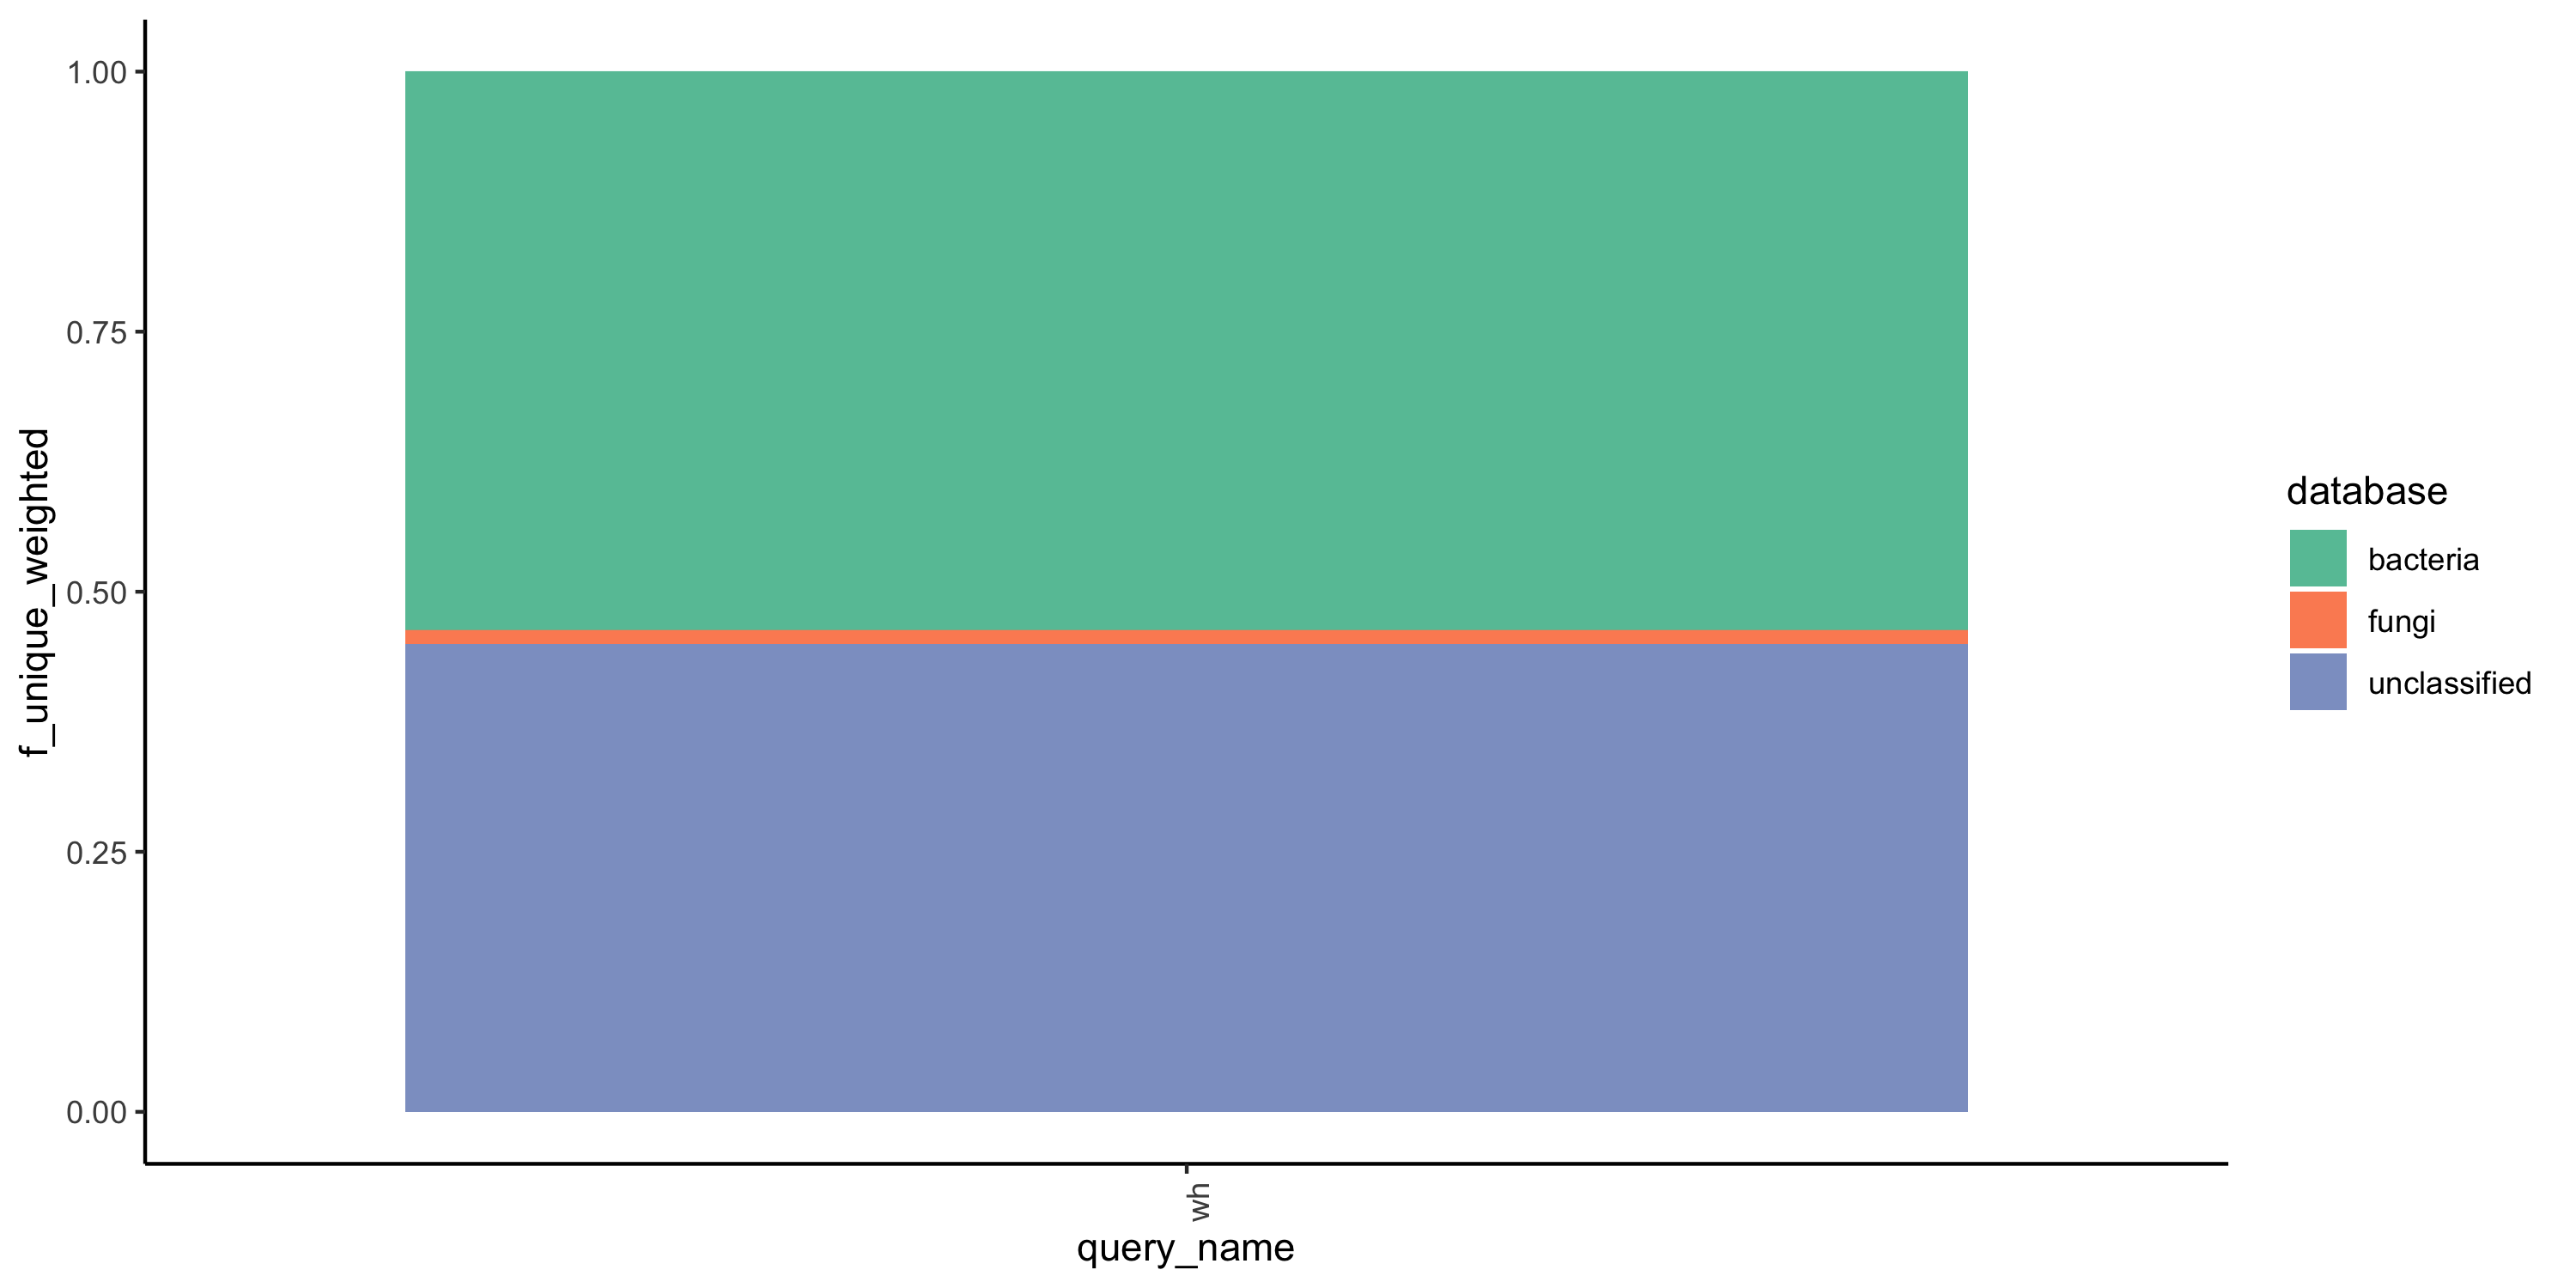

In [9]:
# generate a dataframe that contains information about the percent of the sample that was unclassified.
# then, bind this new dataframe to the sourmash_taxonomy dataframe within the plot
# that way, this information is not carried on beyond this plot.

sourmash_taxonomy_unclassified <- sourmash_taxonomy %>%
  group_by(query_name) %>%
  summarize(sum_f_unique_weighted = sum(f_unique_weighted)) %>%
  mutate(f_unique_weighted = 1 - sum_f_unique_weighted,
         database = "unclassified") %>%
  select(-sum_f_unique_weighted) 

ggplot(sourmash_taxonomy %>% 
         bind_rows(sourmash_taxonomy_unclassified) %>%
         mutate(database = factor(database, levels = c("archaea", "bacteria", "fungi", "protozoa", "viral", "unclassified"))), 
       aes(x = query_name, y = f_unique_weighted, fill = database)) +
  geom_col() +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 90)) +
  scale_fill_brewer(palette = "Set2")

## Sample composition overview

#### How many total genomes (strains) were detected in each metagenome?

Note that while this number represents the total number of genomes that had at least ~50,000bp overlapping with the metagenome, there may be multiple genomes that represent a single strain in the metagenome.
This happens when the strain in the metagenome isn't represented in the database so multiple matching strains are returned.

In [10]:
sourmash_taxonomy %>%
  group_by(query_name) %>%
  tally() %>%
  select(query_name, num_genomes_detected = n)

query_name,num_genomes_detected
<chr>,<int>
wh,290


#### How many total species were detected in each metagenome?

In [11]:
sourmash_taxonomy %>%
  select(lineage, query_name) %>%
  distinct() %>%
  group_by(query_name) %>%
  tally()

query_name,n
<chr>,<int>
wh,186


#### How many total genomes (strains) were detected among the metagenomes for each of the five lineages bacteria, archaea, viral, protozoa, fungi?

In [12]:
sourmash_taxonomy %>%
  group_by(database, query_name) %>%
  tally()

database,query_name,n
<chr>,<chr>,<int>
bacteria,wh,282
fungi,wh,8


**How many distinct lineages were observed across all samples?**

In [13]:
sourmash_taxonomy %>%
  select(lineage) %>%
  distinct() %>%
  nrow()

[1] 186

## plot something

In [14]:
bacteria_plot <- ggplot(sourmash_taxonomy %>% filter(database == "bacteria"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_tableau(palette = "Tableau 20")

fungi_plot <- ggplot(sourmash_taxonomy %>% filter(database == "fungi"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Set1")

# At this filtering threshold, viruses, protozoa, and archaea are not detected in these samples. 
# Uncomment these plots if these lineages are found in your samples.

#viral_plot <- ggplot(sourmash_taxonomy %>% filter(database == "viral"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
#  geom_col() +
#  coord_flip() +
#  facet_wrap(~database, scales = "free_x") +
#  theme_classic() +
#  scale_fill_brewer(palette = "Set2")

#protozoa_plot <- ggplot(sourmash_taxonomy %>% filter(database == "protozoa"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
#  geom_col() +
#  coord_flip() +
#  facet_wrap(~database, scales = "free_x") +
#  theme_classic() +
#  scale_fill_brewer(palette = "Dark2")

#archaea_plot <- ggplot(sourmash_taxonomy %>% filter(database == "archaea"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
#  geom_col() +
#  coord_flip() +
#  facet_wrap(~database, scales = "free_x") +
#  theme_classic() +
#  scale_fill_tableau(palette = "Tableau 10")

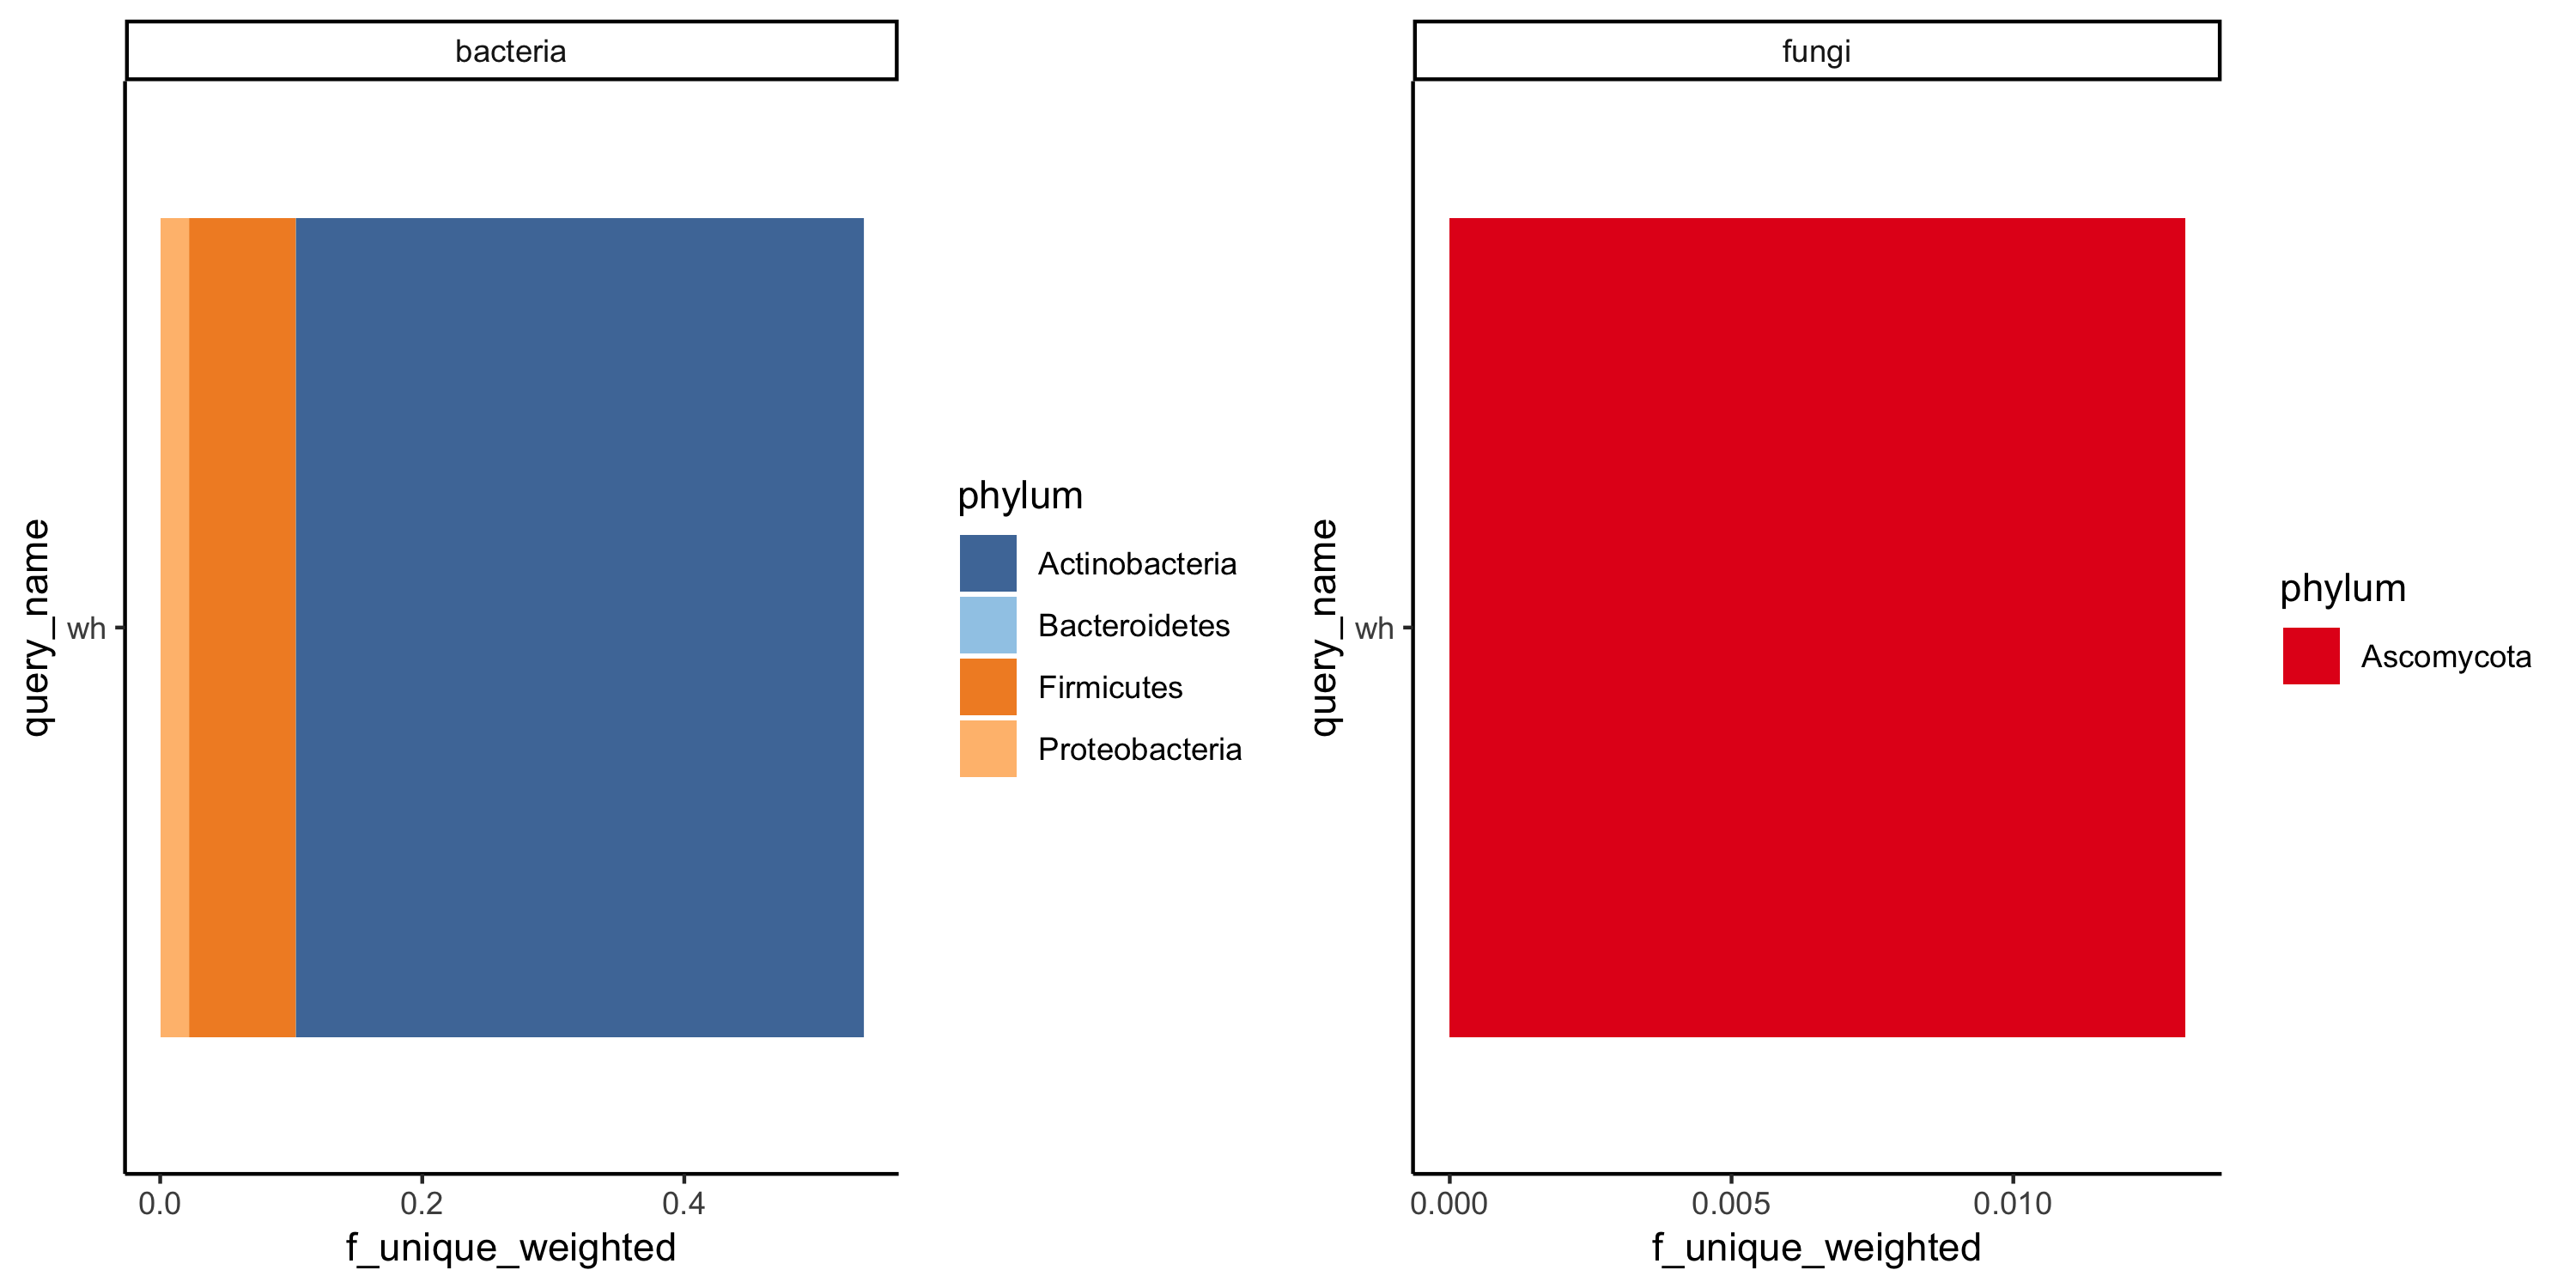

In [15]:
ggarrange(bacteria_plot, fungi_plot, ncol = 2)

## Upset plot of shared lineages observed between samples

The below upset plot shows the number of shared lineages between samples. 
These are full lineages, which may be represented up to the strain level.

In [18]:
# re-read in taxonomy results in list format instead of parsing from the above data
files <- Sys.glob("outputs/sourmash_taxonomy/wh*k31*csv") # list files in the taxonomy folder that contain k31 and end with .csv
sourmash_taxonomy_upset_list <- list()
for(i in 1:length(files)){
    taxonomy <- read_csv(files[i], show_col_types = F) %>% # read in the sourmash taxonomy results
      filter(intersect_bp >= intersect_bp_threshold)       # filter at threshold 
    sample_name <- unique(taxonomy$query_name)             # record the signature name which is currently stored as the column name
    sourmash_taxonomy_upset_list[[i]] <- taxonomy$lineage  # record the lineage names in a list
    names(sourmash_taxonomy_upset_list)[i] <- sample_name  # set the name of the list index to the signature name
}

In [19]:
# re-format the list into format needed to make upset plot
upset_df <- fromList(sourmash_taxonomy_upset_list)

ERROR: Error in `rownames<-`(x, value): attempt to set 'rownames' on an object with no dimensions


In [20]:
# re-derive appropriate domain labels using lineages

# first, make a data frame that has lineage:database mapping
lineage_to_db <- sourmash_taxonomy %>%
  select(database, lineage) %>%
  distinct()

upset_df <- upset_df %>%
  rownames_to_column("lineage") %>%
  left_join(lineage_to_db, by = "lineage")

head(upset_df)

ERROR: Error in rownames_to_column(., "lineage"): object 'upset_df' not found


In [21]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

# uncomment code to get an upset plot not colored by domain
# plot the upset plot
# upset(upset_df, intersect = names(sourmash_taxonomy_list), set_sizes = F, 
#      base_annotations=list(
#          '# lineages'=intersection_size(text=list(vjust=0.4, hjust=.05, angle=90), 
#                                                          text_colors=c(on_background='black', on_bar='black'),
#                                                          mapping=aes(fill='bars_color')) + 
#           scale_fill_manual(values=c('bars_color'='lightgrey'), guide='none'))
#     )

# plot the upset plot
upset(upset_df, intersect = names(sourmash_taxonomy_upset_list), set_sizes = F, 
      base_annotations=list(
          '# lineages'=intersection_size(text=list(vjust=0.4, hjust=.05, angle=90), 
                                                          text_colors=c(on_background='black', on_bar='black'),
                                                          mapping=aes(fill=database)) +
          scale_fill_brewer(palette = "Set2"))
     )

ERROR: Error in upset_data(data, intersect, mode = mode, encode_sets = encode_sets, : Needs at least two indicator variables


## Dig into intersections

In [22]:
# remove the database column so it doesn't get in the way
df_intersection <- upset_df %>%
  select(-database)

# replace 1s with names of column. 
# the [-1] notation subtracts the first column (lineage) from the operation, 
# only applying it to the presence/absence columns from the samples
df_intersection[-1] <- lapply(seq_along(df_intersection)[-1], 
                              function(x) ifelse(df_intersection[[x]] == 1, 
                                                 names(df_intersection)[x], 
                                                 df_intersection[[x]]))
 
# create a new column in the dataframe named "intersection" that records the the groups of samples that share a given lineage
df_intersection <- df_intersection %>%
  unite(col = "intersection", -c("lineage"), sep = "_")

ERROR: Error in select(., -database): object 'upset_df' not found


In [23]:
# print a data frame showing intersections and the number of shared lineages
df_intersection_summarized <- df_intersection %>%
  group_by(intersection) %>%
  summarise(n = n()) %>%
  arrange(desc(n))

df_intersection_summarized

ERROR: Error in group_by(., intersection): object 'df_intersection' not found


In [24]:
# create a named list of intersections, where the name is the samples that share the intersection 
# and the values are the lineages that are shared
list_intersection <- df_intersection %>%
  group_by(intersection) %>%
  summarise(list = list(lineage)) %>%
  mutate(list = setNames(list, intersection)) %>%
  pull(list)

ERROR: Error in group_by(., intersection): object 'df_intersection' not found


In [25]:
# to pull out values from the list, index into the list using any of the intersection names. 
# as written, this cell takes the first intersection in the table above (0_SRR19888427_0_0_0_0),
# uses that intersection name to index into the list, and prints the values for that list 
# (the 208 lineages that were distinct to SRR19888427)
df_intersection_summarized$intersection[1]
list_intersection[[df_intersection_summarized$intersection[1]]]

ERROR: Error in eval(expr, envir, enclos): object 'df_intersection_summarized' not found


In [26]:
# alternatively, you can take an intersection name of interest (e.g. SRR19888423_SRR19888427_SRR19888432_SRR19888434_SRR19888438_SRR19888440)
# and use that intersection name to directly index into the list.
# the code below prints the 165 lineages that are shared by all samples.
list_intersection[['SRR19888423_SRR19888427_SRR19888432_SRR19888434_SRR19888438_SRR19888440']]

ERROR: Error in eval(expr, envir, enclos): object 'list_intersection' not found
